# Bayes Final Project - BART

We did not have it clean. We experimented using several notebooks. Therefore, we had to put it together and execute it again. This is the reason why some graphs and numbers may be different that the ones exposed in the report since every draw changes slightly due to randomness.

In [1]:
df_raw <- read.csv("googleplaystore.csv")
df_review <- read.csv("googleplaystore_user_reviews.csv")
t <- !is.nan(df_review$Sentiment_Polarity)
df_review2 <- subset(df_review, t)
df_2 <- subset(df_raw, !duplicated(df_raw$App))
row.names(df_2) <- df_2$App
for (app in unique(df_review2$App)) {
    s <- subset(df_review2, df_review2$App == app)
    df_2[app, "sentiment_polarity_mean"] <- mean(s$Sentiment_Polarity)
    df_2[app, "sentiment_subjectivity_mean"] <- mean(s$Sentiment_Subjectivity)
    df_2[app, "positive"] <- sum(s$Sentiment == "Positive")
    df_2[app, "negative"] <- sum(s$Sentiment == "Negative")
    df_2[app, "neutral"] <- sum(s$Sentiment == "Neutral")
}

In [2]:
df <- subset(df_2, !is.na(df_2$sentiment_polarity_mean))
df <- subset(df, !is.na(df$Category))
df$positiveRate <- df$positive/(df$negative+df$neutral+df$positive)
df$negativeRate <- df$negative/(df$negative+df$neutral+df$positive)
df$neutralRate <- df$neutral/(df$negative+df$neutral+df$positive)

In [ ]:
write.csv(df, "modified_dataset.csv")

In [3]:
df <- read.csv("modified_dataset.csv")

In [4]:
options(java.parameters = "-Xmx5g")

In [5]:
a <- gsub('\\+','',df$Installs)
a <- gsub(',','',a)
df$install_interval <- strtoi(a)


a <- gsub('\\M','',df$Size)
a <- gsub('Varies with device','',a)
df$Msize <- strtoi(a)


a <- gsub("\\$","",df$Price)
df$price <- as.numeric(a)

In [38]:
smp_size <- floor(0.70 * nrow(df))

train_ind <- sample(seq_len(nrow(df)), size = smp_size)

train <- df[train_ind, ]
test <- df[-train_ind, ]
y_test <- test$Rating
y_train <- train$Rating
#X_train <- train[c("neutralRate", "sentiment_polarity_mean", "sentiment_subjectivity_mean", "install_interval", "Reviews", "Msize", "price", "positive", "negative", "neutral")]
#X_test <- test[c("neutralRate", "sentiment_polarity_mean", "sentiment_subjectivity_mean", "install_interval", "Reviews", "Msize", "price", "positive", "negative", "neutral")]
X_train <- train[c( "negativeRate", "neutralRate", "sentiment_polarity_mean")]
X_test <- test[c("negativeRate", "neutralRate", "sentiment_polarity_mean")]
#X_train <- train[c("sentiment_polarity_mean", "install_interval", "Reviews")]
#X_test <- test[c("sentiment_polarity_mean", "install_interval", "Reviews")]

In [ ]:
df2 <- cbind(df$Rating, df$neutralRate, df$negativeRate, df$sentiment_polarity_mean)
library(psych)
pairs.panels(df2, pch=21,main="Correlation", ci=T)
cor.test(df$Rating, df$neutralRate)
cor.test(df$Rating, df$negativeRate)
cor.test(df$Rating, df$sentiment_polarity_mean)

In [19]:
length(df$neutralRate)
length(df$neutral)

[1] 816

[1] 816

In [20]:
dim(X_train)
dim(X_test)

[1] 571   3

[1] 245   3

In [21]:
library(bartMachine)
library(BayesTree)

In [26]:
get_accuracy <- function(y_hat, y_test, error){
    diff <- abs(y_hat - y_test)
    aux <- diff < (error*y_hat/100)
    acc <- sum(aux)/length(y_test)
    return (acc)
}

In [64]:
b <- bart(x.train = X_train, y.train = y_train, x.test = X_test)



Running BART with numeric y

number of trees: 200
Prior:
	k: 2.000000
	degrees of freedom in sigma prior: 3
	quantile in sigma prior: 0.900000
	power and base for tree prior: 2.000000 0.950000
	use quantiles for rule cut points: 0
data:
	number of training observations: 571
	number of test observations: 245
	number of explanatory variables: 3


Cutoff rules c in x<=c vs x>c
Number of cutoffs: (var: number of possible c):
(1: 100) (2: 100) (3: 100) 


Running mcmc loop:
iteration: 100 (of 1100)
iteration: 200 (of 1100)
iteration: 300 (of 1100)
iteration: 400 (of 1100)
iteration: 500 (of 1100)
iteration: 600 (of 1100)
iteration: 700 (of 1100)
iteration: 800 (of 1100)
iteration: 900 (of 1100)
iteration: 1000 (of 1100)
iteration: 1100 (of 1100)
time for loop: 35

Tree sizes, last iteration:
3 3 2 2 2 2 2 3 2 2 2 2 3 3 2 3 3 2 2 3 
2 2 2 2 3 3 2 2 4 2 2 2 2 3 2 2 3 2 2 3 
2 1 2 2 2 2 2 3 2 4 2 2 2 3 2 2 2 2 1 2 
2 2 4 3 2 3 2 2 2 2 3 2 3 2 2 2 3 3 2 3 
1 2 2 3 2 4 5 1 2 2 3 2 2 2 3 2 2 2 

In [24]:
SSE_200 <- sum((b$yhat.test.mean-y_test)^2)
SSE_200

[1] 20.38222

In [136]:
round(b$yhat.test.mean[1:10],1)
y_test[1:10]

[1] 4.4 4.3 4.4 4.4 4.2 4.2 4.1 4.2 4.4 4.2

[1] 4.5 4.7 4.9 4.6 4.3 4.0 4.4 4.2 4.5 4.3

In [66]:
a <- get_accuracy(log(y_hat), log(y_test), 6)
a
0.661224489795918 # 5 variables
0.644897959183673 # 4 variables
0.604081632653061 # pos neg, sentiment polarity

[1] 0.7836735

[1] 0.6612245

[1] 0.644898

[1] 0.6040816

In [39]:
bart_object_default <- bartMachine(X_train, y_train)

bartMachine initializing with 50 trees...
bartMachine vars checked...
bartMachine java init...
bartMachine factors created...
bartMachine before preprocess...
bartMachine after preprocess... 4 total features...
bartMachine sigsq estimated...
bartMachine training data finalized...
Now building bartMachine for regression ...
evaluating in sample data...done


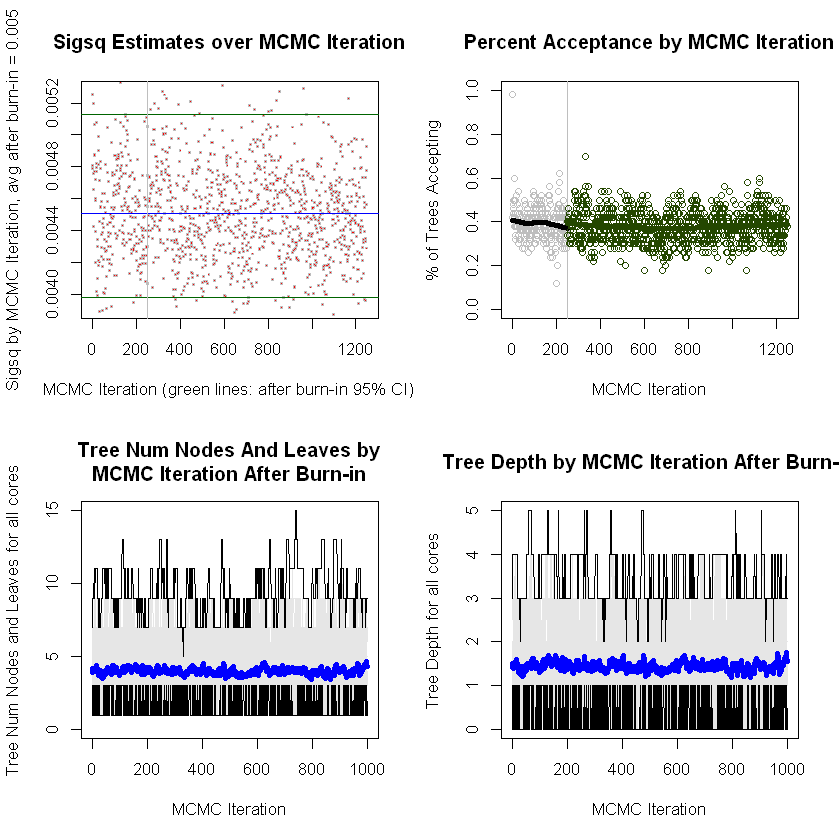

In [26]:
plot_convergence_diagnostics(bart_object_default)

In [61]:
yhat <- predict(bart_object_default,X_test)

In [62]:
yhat <- round(yhat,1)

In [49]:
bart_object<- bartMachine(X_train, log(y_train), num_trees = 30, q = 0.90, nu = 3, use_missing_data = TRUE, k = 5)
#bart_object<- bartMachine(X_train, y_train)
#k: 5 nu, q: 3, 0.9 m: 200 

bartMachine initializing with 30 trees...
bartMachine vars checked...
bartMachine java init...
bartMachine factors created...
bartMachine before preprocess...
bartMachine after preprocess... 5 total features...
bartMachine sigsq estimated...
bartMachine training data finalized...
Now building bartMachine for regression ...Missing data feature ON. 
evaluating in sample data...done


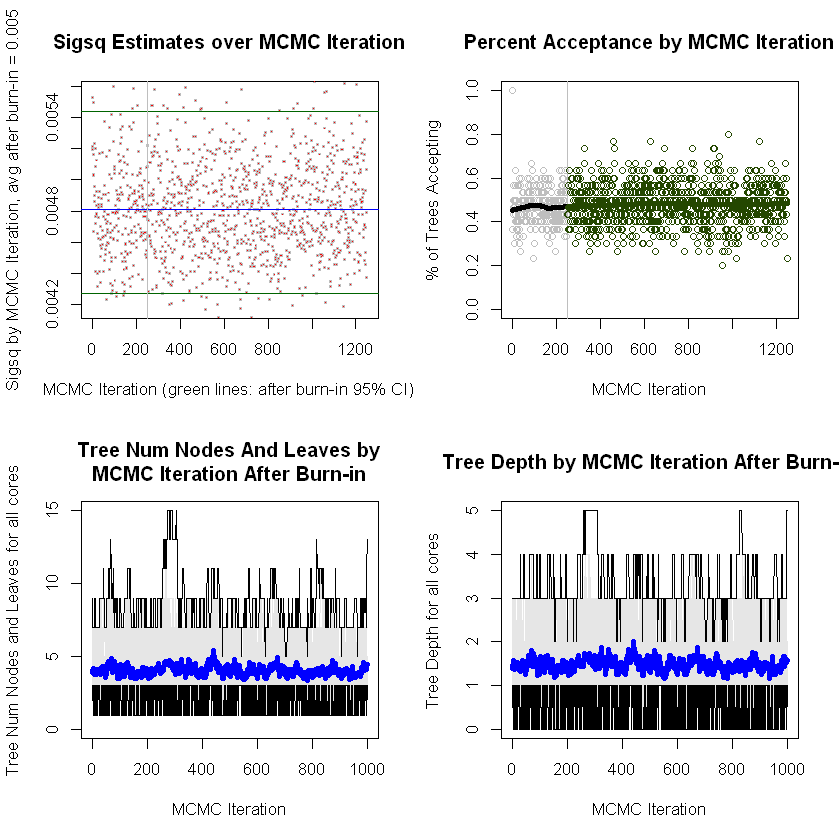

In [50]:
plot_convergence_diagnostics(bart_object)

.....


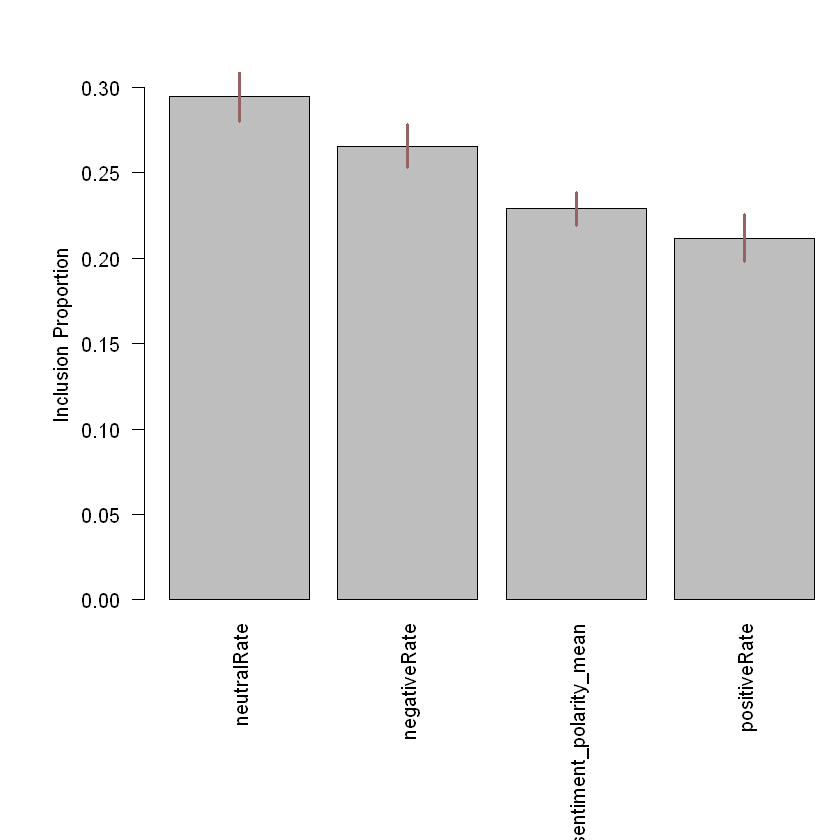

In [221]:
investigate_var_importance(bart_object)

In [37]:
yhat <- predict(bart_object, X_test)

In [206]:
round(yhat[0:10],1)
y_test[0:10]

[1] 4.4 4.3 4.4 4.4 4.2 4.3 4.1 4.2 4.3 4.2

[1] 4.5 4.7 4.9 4.6 4.3 4.0 4.4 4.2 4.5 4.3

In [42]:
SSE_200 <- sum((yhat-log(y_test))^2)
SSE_200

[1] 1.221301

In [208]:
y_hat <- round(yhat,1)
a <- get_accuracy(log(y_hat), log(y_test), 5)
a
0.640816326530612 # 5 variables
0.63265306122449 # 4 vars
0.616326530612245 # 3 vars pos, neg, sent polarity

[1] 0.844898

[1] 0.6408163

[1] 0.6326531

[1] 0.6163265

In [143]:
bart_object2 <- bartMachineCV(X_train, y_train)

  bartMachine CV try: k: 2 nu, q: 3, 0.9 m: 50 
.....
  bartMachine CV try: k: 2 nu, q: 3, 0.9 m: 200 
.....
  bartMachine CV try: k: 2 nu, q: 3, 0.99 m: 50 
.....
  bartMachine CV try: k: 2 nu, q: 3, 0.99 m: 200 
.....
  bartMachine CV try: k: 2 nu, q: 10, 0.75 m: 50 
.....
  bartMachine CV try: k: 2 nu, q: 10, 0.75 m: 200 
.....
  bartMachine CV try: k: 3 nu, q: 3, 0.9 m: 50 
.....
  bartMachine CV try: k: 3 nu, q: 3, 0.9 m: 200 
.....
  bartMachine CV try: k: 3 nu, q: 3, 0.99 m: 50 
.....
  bartMachine CV try: k: 3 nu, q: 3, 0.99 m: 200 
.....
  bartMachine CV try: k: 3 nu, q: 10, 0.75 m: 50 
.....
  bartMachine CV try: k: 3 nu, q: 10, 0.75 m: 200 
.....
  bartMachine CV try: k: 5 nu, q: 3, 0.9 m: 50 
.....
  bartMachine CV try: k: 5 nu, q: 3, 0.9 m: 200 
.....
  bartMachine CV try: k: 5 nu, q: 3, 0.99 m: 50 
.....
  bartMachine CV try: k: 5 nu, q: 3, 0.99 m: 200 
.....
  bartMachine CV try: k: 5 nu, q: 10, 0.75 m: 50 
.....
  bartMachine CV try: k: 5 nu, q: 10, 0.75 m: 200 
.....
 

In [194]:
yhat <- predict(bart_object2, X_test)
round(yhat[0:10],1)
y_test[0:10]

[1] 4.4 4.3 4.4 4.4 4.1 4.3 4.1 4.2 4.3 4.2

[1] 4.5 4.7 4.9 4.6 4.3 4.0 4.4 4.2 4.5 4.3

In [195]:
y_hat <- round(yhat,1)
a <- get_accuracy(log(y_hat), log(y_test), 5)
a

[1] 0.8408163

In [114]:
0.820408163265306 # 3 variables

[1] 0.8204082

In [116]:
0.775510204081633 # 5 variables

[1] 0.7755102

In [153]:
0.771428571428571 # 4 variables

[1] 0.7714286

num_trees = ..5..5..5..5..5..5..5..5..5..5..5..5..5..5..5..5..5..5..5..5..10..10..10..10..10..10..10..10..10..10..10..10..10..10..10..10..10..10..10..10..20..20..20..20..20..20..20..20..20..20..20..20..20..20..20..20..20..20..20..20..30..30..30..30..30..30..30..30..30..30..30..30..30..30..30..30..30..30..30..30..40..40..40..40..40..40..40..40..40..40..40..40..40..40..40..40..40..40..40..40..50..50..50..50..50..50..50..50..50..50..50..50..50..50..50..50..50..50..50..50..100..100..100..100..100..100..100..100..100..100..100..100..100..100..100..100..100..100..100..100..150..150..150..150..150..150..150..150..150..150..150..150..150..150..150..150..150..150..150..150..200..200..200..200..200..200..200..200..200..200..200..200..200..200..200..200..200..200..200..200


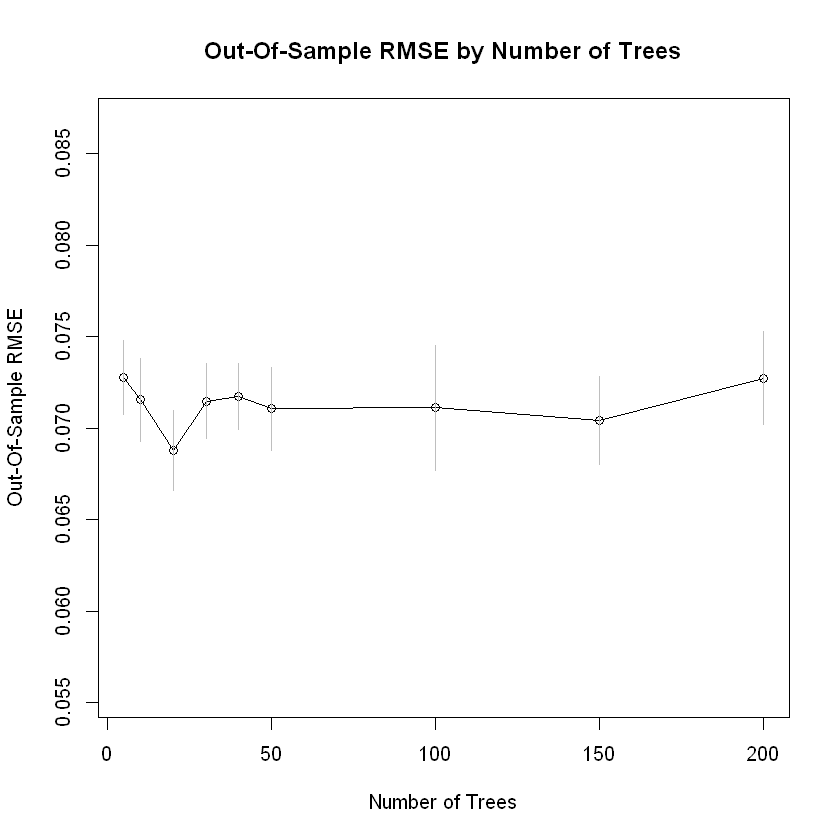

In [48]:
rmse_by_num_trees(bart_object, num_replicates = 20)